In [1]:
import random
import xml.etree.ElementTree as ET
from typing import List, Tuple

import kornia as K
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from tqdm import tqdm

In [2]:
def get_meta(index: int)-> Tuple[List[str], List[int]]:

    # read annotation file
    soln_root = f'/home/linyan/data/dac/train/Annotations/{index:05}.xml'
    soln_root = ET.parse(soln_root).getroot()

    objects = []
    labels = []
    
    # find all objects in frame
    for obj in soln_root.findall('object'):
    
        obj_class = obj.find('name').text
        x_min = int(obj.find('bndbox/xmin').text)
        y_min = int(obj.find('bndbox/ymin').text)
        x_max = int(obj.find('bndbox/xmax').text)
        y_max = int(obj.find('bndbox/ymax').text)
        
        labels.append(obj_class)
        objects.append(list((x_min, y_min, x_max, y_max)))
    
    objects = torch.tensor(objects, dtype=torch.int)

    return labels, objects
    
def get_image(index: int)-> torch.Tensor:
    img_path = f'/home/linyan/data/dac/train/JPEGImages/{index:05}.jpg'
    return read_image(img_path)

class_palette = {'Motor Vehicle': (204,78,210),
        'Non-motorized Vehicle': (0,192,255),
        'Pedestrian': (0,131,0),
        'Traffic Light-Red Light': (240,176,0),
        'Traffic Light-Yellow Light': (254,100,38),
        'Traffic Light-Green Light': (0,0,255),
        'Traffic Light-Off': (182,117,46)}

patches = [mpatches.Patch(color=np.array(val)/255., label=key) for key, val in class_palette.items()]

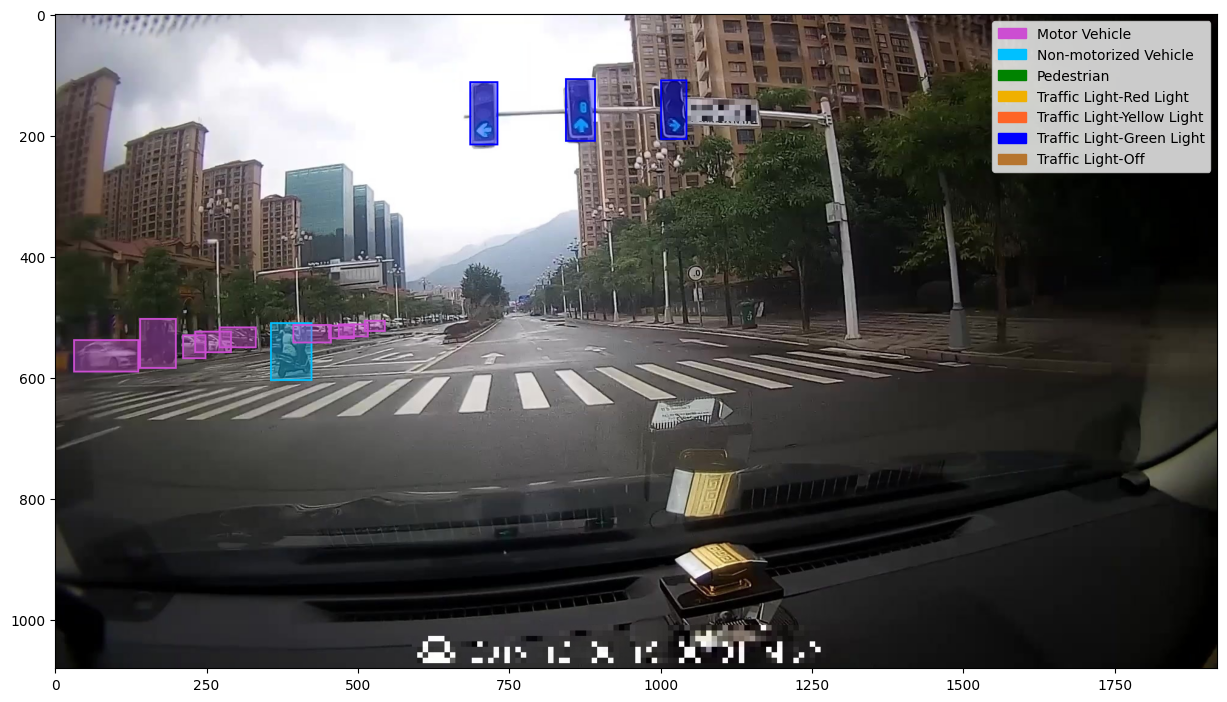

In [3]:
rand_index = random.randint(1, 2500)
labels, bbox = get_meta(index=rand_index)
image = get_image(index=rand_index)
colors = [class_palette.get(label) for label in labels]

image = draw_bounding_boxes(image, bbox, colors=colors, fill=True, font_size=10, width=3)
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(K.tensor_to_image(image))
plt.legend(handles=patches)

In [4]:
counts = {label:0 for label in class_palette.keys()}
areas = list()
not_found = list()

xlarge = list()
xsmall = list()

for idx in tqdm(range(1, 12000)):
    
    try:
        labels, bbox = get_meta(idx)

        for l, b in zip(labels, bbox):

            counts[l] += 1
            area = (b[2]-b[0])*(b[3]-b[1])
            
            areas.append(area)
            if area < 100:
                xsmall.append(idx)
            elif area > 10000:
                xlarge.append(idx)
            
    except:
        not_found.append(idx)

100%|██████████| 11999/11999 [00:01<00:00, 6970.38it/s]


In [5]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zero(len(d))
    return data[s<m]

In [6]:
areas = reject_outliers(np.array(areas))

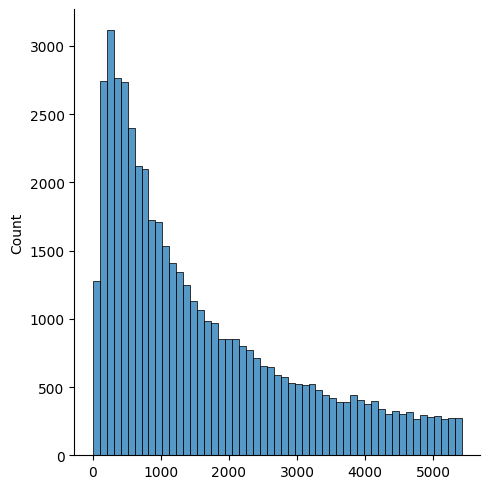

In [7]:
sns.displot(areas)